In [1]:
import sys
sys.path.append('../../VQC-Lite')
from IPython.display import Image
from IPython.display import HTML
HTML(open('stylesheet.css').read())

# An Introduction to VQC
Author: Kevin Shen

In this notebook, we will introduce the basics of VQC. You will see how a variational circuit is constructed layer by layer. For more details please refer to the documentation.

## Circuit Stack

The structure of a typical VQC can be divided into 4 levels, which from bottom to top are: gate, block, layer and circuit.

In [2]:
import numpy as np
from circuit_stack.circuit_mps import MPS
from circuit_stack.layer import RCMPSLayer, IRLayer
from circuit_stack.block import Block_CNOT, Block_GU1
from circuit_stack.gate import CNOT, GU1

### Gate
<div class=Des>
Gates are at the bottom layer of the stack. Gates can be either parametrized or unparametrized. Parametrized gates take parameters as input, while unparametrized gates are without input. Functions of both kinds output a unitary matrix in jax numpy array form.

In [3]:
gate = CNOT()
print(gate)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]


<Div class=Not> Above is a controlled-X gate (CNOT) gate, which is a native entangling gate for many current superconducting quantum computers.

### Block
<div class=Des>
A block is the repeating unit in a layer. A block consists of $\geq$ 1 parameterized or fixed gate(s).
The most important attributes of a block are three lists, called "gs", "il" and "npl".
    
1. "gs" stands for gate sequence,
    which is a list of strings (names of the gates). The functions realizing the gates
    are defined in the file gate.py. The strings will be mapped to the functions at the circuit level.

2. "il" stands for index list,
    which is a list of lists of integers called 'local indices', which defines the qubits on which
    the gates apply.

3. "npl" stands for number of parameter list,
    which is a list storing the number of parameters each gate takes.

In [4]:
block = Block_CNOT()
print('Gate Sequence:', block.gs)
print('Act on qubits:', block.il)
print('Requiring _ parameters:', block.npl)

Gate Sequence: ['CNOT', 'GU1', 'GU1']
Act on qubits: [[0, 1], [0], [1]]
Requiring _ parameters: [0, 3, 3]


<Div class=Not>
Above is a block acting on 2 qubits. It consists of a CNOT gate followed by 2 general single-qubit unitaries (GU1) on each qubit. Each GU1 reuqires 3 parameters.

### Layer
<div class=Des>
A layer is a component of the circuit, which could repeat itself a few times in the circuit. A layer
is an arrangement of repeating blocks that covers all qubits. The most important attributes of a circuit are also "gs", "il" and "npl", which are formed by concatenating the ones
of its block components.

In [5]:
layer = RCMPSLayer(block, nq=3)
print('Gate Sequence:', layer.gs)
print('Act on qubits:', layer.il)
print('Requiring _ parameters:', layer.npl)

Gate Sequence: ['CNOT', 'GU1', 'GU1', 'CNOT', 'GU1', 'GU1']
Act on qubits: [[0, 1], [0], [1], [1, 2], [1], [2]]
Requiring _ parameters: [0, 3, 3, 0, 3, 3]


<Div class=Not>
Above is a layer of CNOT blocks acting on 3 qubits. As there are two pairs of neighboring qubits $(0,1)$ and $(1,2)$, the layer consists of 2 blocks.

### Circuit
<div class=Des>     
Circuits are at the top level of the stack. The most important attributes of a circuit are also "gs", "il" and "npl", which are formed by concatenating the ones of its layer components.

In [6]:
circuit = MPS(layer, nl=2, pmd={'GU1':0})
print('Gate Sequence:', circuit.gs)
print('Act on qubits:', circuit.il)
print('Requiring _ parameters:', circuit.npl)

Gate Sequence: ['CNOT', 'GU1', 'GU1', 'CNOT', 'GU1', 'GU1', 'CNOT', 'GU1', 'GU1', 'CNOT', 'GU1', 'GU1']
Act on qubits: [[0, 1], [0], [1], [1, 2], [1], [2], [0, 1], [0], [1], [1, 2], [1], [2]]
Requiring _ parameters: [0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3]


<Div class=Not>
Above is a circuit of 2 CNOT layers. The argument "pmd" stands for the parameterization method dictionary, which defines how a gate should be parametrized if there are multiple ways to do so. There are many ways to parametrized GU1 gates,and that's why we need to specify it here.

In [7]:
new_layer = IRLayer(Block_GU1())
circuit += new_layer
print('Gate Sequence:', circuit.gs)
print('Act on qubits:', circuit.il)
print('Requiring _ parameters:', circuit.npl)

Gate Sequence: ['CNOT', 'GU1', 'GU1', 'CNOT', 'GU1', 'GU1', 'CNOT', 'GU1', 'GU1', 'CNOT', 'GU1', 'GU1', 'GU1', 'GU1', 'GU1', 'GU1']
Act on qubits: [[0, 1], [0], [1], [1, 2], [1], [2], [0, 1], [0], [1], [1, 2], [1], [2], [0], [1], [2], [3]]
Requiring _ parameters: [0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3]


<Div class=Not>
Above we added a layer of GU1 gates acting on each qubit. You may see the change in "gs", "il" and "npl".

In [8]:
nparam = circuit.get_np() 
print(nparam, "parameters in total!")
params = np.random.uniform(size=nparam)
print('Output state:', circuit.run_with_param_input(params))

36 parameters in total!
Output state: [[[[ 9.27685052e-02-0.07779589j  1.77142527e-02-0.01819179j]
   [-2.52176821e-01+0.30284327j -4.62240987e-02+0.06851619j]]

  [[-4.70696017e-02+0.20689313j -5.45266457e-03+0.04416415j]
   [ 1.01417035e-01-0.24627799j  1.59611050e-02-0.0535298j ]]]


 [[[-7.55824149e-05+0.14136371j  2.96933018e-03+0.02949847j]
   [-3.01757812e-01+0.6188493j  -4.98967059e-02+0.13550082j]]

  [[-6.07876480e-02+0.1348249j  -9.83689167e-03+0.02941611j]
   [ 8.19850862e-02-0.38643813j  8.94675776e-03-0.08236521j]]]]


<Div class=Not>
Above we found fed the circuit with 36 parameters, executed it and obtained a statevector as output.

## Circuit Stack Pennylane

Let's now switch to the Pennylane version of the circuit stack. It consists of 3 levels, which from bottom to top are: gate, block and circuit.

Note that because of functions such as "qml.MPS" and "qml.broadcast", the arrangement of blocks could be
easily handled at the circuit level for many common Ansätze. Thus, at the moment the "layer" level which exists in the previous circuit stack is omitted here. However, when more complicated Ansätze come in the future, maybe it's better to also introduce the layer here.

In [9]:
from circuit_stack_pennylane.circuit_mps import MPS_CNOT_P
from circuit_stack_pennylane.block import Block_GU1_P

In [10]:
pm1=2
irb = Block_GU1_P()
circuit = MPS_CNOT_P(nl=2, nq=4, irb=irb, pm1=pm1)

<div class=Des> Above we construct a VQC with one layer of initial rotations with GU1, followed by 2 layers of CNOT blocks. Note that this is not the same circuit as in the previous section. The circuit is plotted below.

/Users/kevinshen/Documents/Github/VQC-Lite/venv/lib/python3.8/site-packages/pennylane/ops/qubit/matrix_ops.py:92: UserWarning: Operator [[nan+nanj nan+nanj]
 [nan+nanj nan+nanj]]
 may not be unitary.Verify unitarity of operation, or use a datatype with increased precision.
  warnings.warn(


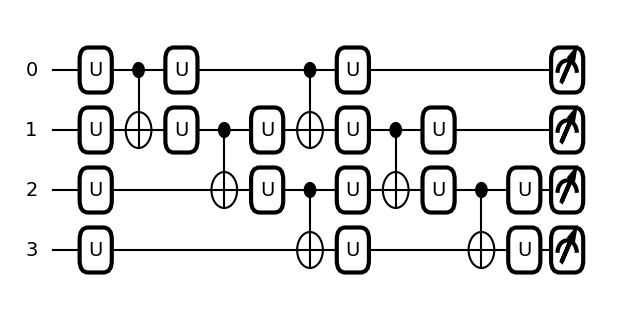

In [11]:
circuit.plot(fig_size=(6,3))